In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os 

os.chdir("../")

from einops import rearrange
import einops 
import numpy as np
import torch

from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from typing import List
from torchvision.transforms import Compose, ToTensor, Lambda

In [2]:
dataset = load_dataset("nielsr/CelebA-faces")


Using custom data configuration nielsr--CelebA-faces-ffaff57f221b8a22


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /home/johannes/.cache/huggingface/datasets/nielsr___parquet/nielsr--CelebA-faces-ffaff57f221b8a22/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 202599
    })
})

In [24]:
dataset = load_dataset("nielsr/CelebA-faces")
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 32
TIMESTEPS = 200

UPSCALE_IMAGE_SIZE = 128

device = "cuda" if torch.cuda.is_available() else "cpu"

_dataset_transform = transforms.Compose(
    [   
        transforms.Resize((UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)

def normalize(examples):
    
    examples["x"] = [_dataset_transform(image) for image in examples["image"]]
    del examples["image"]

    return examples

transformed_dataset = dataset.with_transform(normalize)

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=BATCH_SIZE, shuffle=True)

reverse_transform = transforms.Compose([
     # transforms.Lambda(lambda t: t[0, :, :, :]),
     transforms.Lambda(lambda t: torch.clip(t, -1, 1)),
     transforms.Lambda(lambda t: (t + 1) / 2),
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.to("cpu"),),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     # transforms.ToPILImage(),
])

reverse_transform2 = transforms.Compose([
     # transforms.Lambda(lambda t: t[0, :, :, :]),
     transforms.Resize(128),
     transforms.Lambda(lambda t: (t + 1) / 2),
     # transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.to("cpu"),),
     # transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     # transforms.ToPILImage(),
])

Using custom data configuration nielsr--CelebA-faces-ffaff57f221b8a22
Found cached dataset parquet (/home/johannes/.cache/huggingface/datasets/nielsr___parquet/nielsr--CelebA-faces-ffaff57f221b8a22/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [80]:
from diffusion import Diffusion

diffusion = Diffusion(
    timesteps=TIMESTEPS,
)

In [77]:
from unet import UnetConditional

unet_conditional = UnetConditional(
    channels=[32, 64, 128, 256],
    in_channels=CHANNELS,
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
    nclasses=10,
)
unet_conditional

UnetConditional(
  (_init_conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (_time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=96, out_features=384, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=384, out_features=384, bias=True)
  )
  (_down_sampling_layers): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (_time_embedder): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=32, bias=True)
        )
        (_block1): ConvBlock(
          (_conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (_gnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (_actfunc): SiLU()
        )
        (_block2): ConvBlock(
          (_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (_gnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (_actfunc): SiLU()
        )
        (_res_conv): Conv

In [17]:
from unet import Unet

unet = Unet(
    channels=[32, 64, 128, 256],
    in_channels=1,
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
)

functools.partial(<class 'utils.ResnetBlock'>, norm_groups=8)


In [ ]:
y = _generate_image(
    model=unet,
    diffusion=diffusion,
    timesteps=TIMESTEPS,
    shape=[1, 1, UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE],
    device=device,
)

In [52]:
image = reverse_transform(y[-1, :, :, :])
image.save("tmp.png")

In [77]:
x_noised, noise, time = diffusion.forward(batch["x"])

y = unet_conditional.forward(
    x=x_noised.to(device),
    time=time.to(device),
    classes=batch["label"].to(device),
)

In [32]:
from diffusion import Diffusion

def plot_process_backward(
    model: torch.nn.Module,
    diffusion: Diffusion,
    timesteps: int,
    shape: List[int],
    device: str,
    klass: int = None,
):
    
    klass = torch.Tensor([klass]).to(device)
    
    with torch.no_grad():

        x = torch.randn(shape, device=device)
        timesteps_iter = list(range(timesteps))
        timesteps_iter.reverse()
        
        Y = [x]
        
        for t in timesteps_iter:

            t = torch.Tensor([t]).long().to(device)

            predicted_noise = model.forward(
                x,
                t,
            #    klass
            )

            x = diffusion.backward(x, predicted_noise, t)

            Y.append(x)
            
        return torch.cat(Y, dim=0)

def plot_process(
    model: torch.nn.Module,
    x: torch.Tensor,
    label: torch.Tensor,
    diffusion: Diffusion,
    device: str,
):
    
    model.to(device)

    assert len(x.shape) == 3
    
    X, Y = [], []
    
    with torch.no_grad():

        for timestep in range(diffusion._timesteps):

            t = torch.Tensor([timestep]).long()

            x_noised, noise, _ = diffusion.forward(
                x=x.unsqueeze(0),
                t=t,
            )
            
            y = model.forward(
                x=x_noised.to(device),
                time=t.to(device),
                classes=label.to(device),
            )

            Y.append(y.to("cpu")[0, :, :, :])
            X.append(x_noised[0, :, :, :].to("cpu"))

    
    return X, Y


def diffusion_process(
    x: torch.Tensor,
    diffusion: Diffusion,
):
    
    assert len(x.shape) == 3
    
    X = []

    for timestep in range(diffusion._timesteps):

        t = torch.Tensor([timestep]).long()

        x_noised, noise, _ = diffusion.forward(
            x=x,
            t=t,
        )

        X.append(x_noised.to("cpu"))

        
    return X

<IPython.core.display.Javascript object>


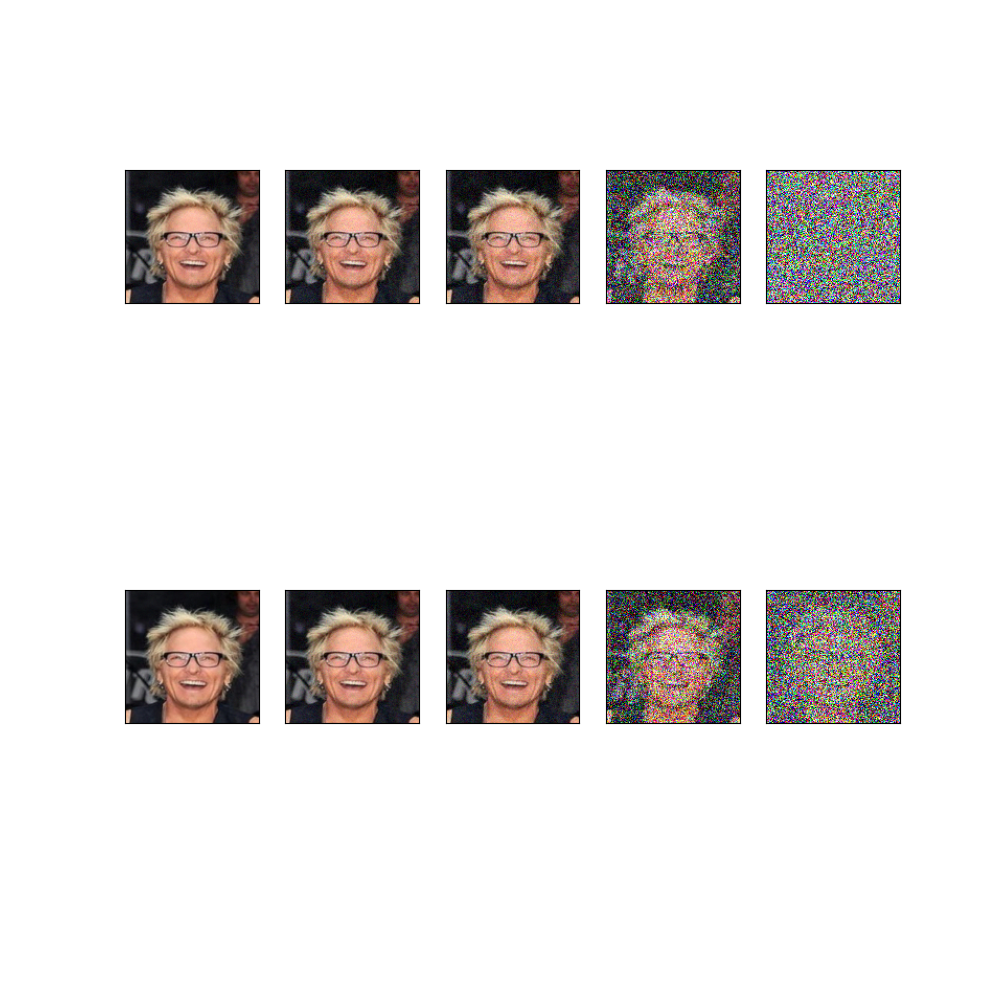

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib notebook

batch = next(iter(dataloader))

diffusion_cosin = Diffusion(
    timesteps=TIMESTEPS,
    schedular="cosine",
)

diffusion_linear = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
)

Xcosin = diffusion_process(
    x=batch["x"][0, :, :, :],
    diffusion=diffusion_cosin,
)

Xlinear = diffusion_process(
    x=batch["x"][0, :, :, :],
    diffusion=diffusion_linear,
)

DISPLAY_NIMAGES = 5

indicies = np.linspace(0, len(Xcosin) -1 , DISPLAY_NIMAGES, dtype=int)

fig, axs = plt.subplots(2, DISPLAY_NIMAGES, gridspec_kw={'height_ratios': [1, 2]}, figsize=(10,10))

for i, process_i in enumerate([0, 5, 10, 100, 199]):
    
    x = reverse_transform(Xcosin[process_i])
    y = reverse_transform(Xlinear[process_i])
    
    axs[0][i].imshow(x)
    
    axs[1][i].imshow(y)
    
    axs[0][i].axes.get_xaxis().set_visible(False)
    axs[0][i].axes.get_yaxis().set_visible(False)

    axs[1][i].axes.get_xaxis().set_visible(False)
    axs[1][i].axes.get_yaxis().set_visible(False)

In [52]:
plt.plot(diffusion_linear._sqrt_alphas_cumprod.numpy())

In [51]:
plt.plot(diffusion_cosin._sqrt_alphas_cumprod.numpy())

In [109]:
diffusion_linear = Diffusion(
    timesteps=1000,
    schedular="linear",
)

plt.plot(diffusion_linear._sqrt_alphas_cumprod.numpy())

<IPython.core.display.Javascript object>


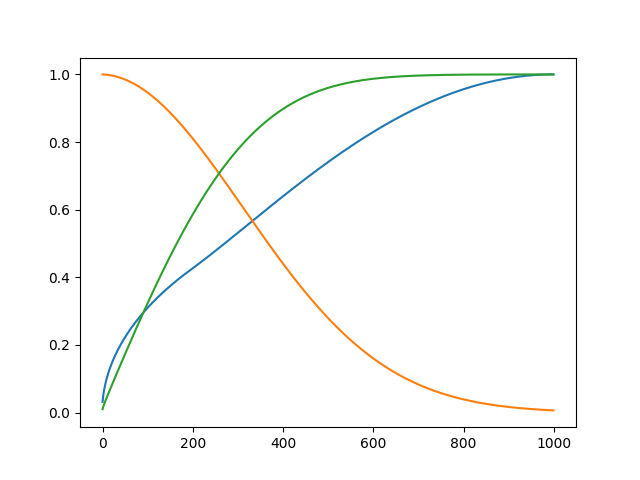

In [108]:
diffusion_cosin = Diffusion(
    timesteps=1000,
    schedular="cosine",
)

plt.plot(diffusion_cosin._sqrt_one_minus_alphas_cumprod.numpy())

In [110]:
diffusion_cosin = Diffusion(
    timesteps=TIMESTEPS,
    schedular="cosine",
)

plt.plot(diffusion_linear._sqrt_one_minus_alphas_cumprod.numpy())

In [99]:
diffusion_cosin._sqrt_alphas_cumprod.numpy().sum()

608.19836

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

diffusion = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
)

from unet import UnetConditional, Unet

model = Unet(
    channels=[64, 128, 256, 512],
    in_channels=CHANNELS,
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
    # nclasses=10,
)


In [ ]:
writer = SummaryWriter("runs/celeba")

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

iteration = 0

for e in range(500):

    for step, batch in enumerate(dataloader):

        iteration += 1

        x = batch["x"].to(device)
        #l = batch["label"].to(device)
        
        max_t = np.min([int(50 + e ** 1.1), TIMESTEPS])
        
        time = None # torch.randint(0, max_t, (x.shape[0],), device=x.device).long()
        
        x_noised, noise, time = diffusion.forward(x, time)

        noise_predicted = model.forward(
            x=x_noised.to(device),
            time=time.to(device),
            #classes=l.to(device),
        )

        loss = diffusion.loss(noise, noise_predicted)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("loss", loss, iteration)
    
    print(e)
    
    y = plot_process_backward(
        model=model,
        diffusion=diffusion,
        timesteps=TIMESTEPS,
        shape=[1, CHANNELS, UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE],
        device=device,
        klass=1,
    )
        
    writer.add_image(f'images',np.asarray(reverse_transform(y[-1, :, :, :])), e, dataformats='HWC')

0


<IPython.core.display.Javascript object>


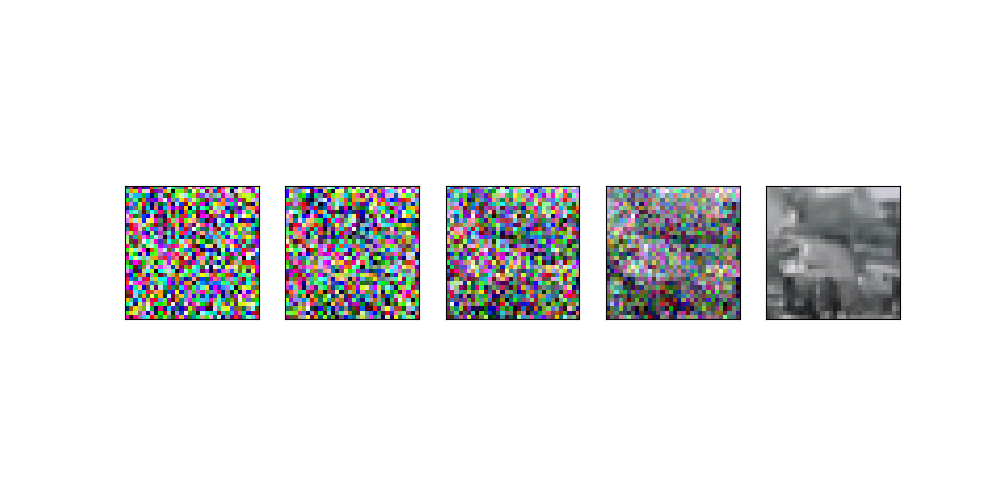

In [88]:
Y = _generate_image(
    model=model,
    diffusion=diffusion,
    timesteps=TIMESTEPS,
    shape=[1, CHANNELS, UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE],
    device=device,
    klass=9,
)

indicies = np.linspace(0, len(Y) -1 , 5, dtype=int)

fig, axs = plt.subplots(1, len(indicies), figsize=(10, 5))

for i, process_i in enumerate([0, 50, 100, 150, 199]):
    
    y = reverse_transform(Y[process_i])
    
    axs[i].imshow(y)
    
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)

<IPython.core.display.Javascript object>


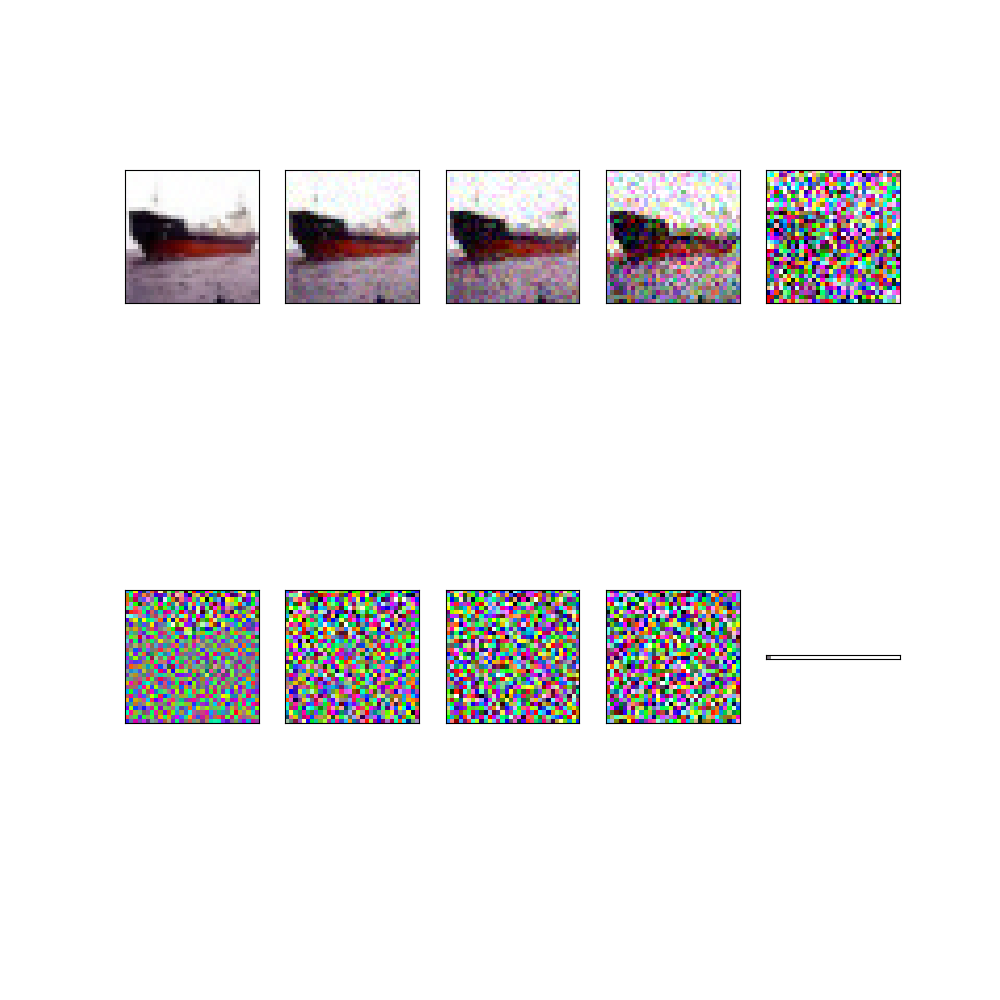

In [59]:
batch = next(iter(dataloader))

idx = 0

X, Y = plot_process(
    model=model,
    x=batch["x"][idx, :, :, :],
    label=batch["label"][idx],
    diffusion=diffusion,
    device="cuda",
)

import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow

%matplotlib notebook

indicies = np.linspace(0, len(X) -1 , 5, dtype=int)

fig, axs = plt.subplots(2, len(indicies), gridspec_kw={'height_ratios': [1, 2]}, figsize=(10,10))

i = 0

for i, process_i in enumerate([0, 10, 20, 50, 199]):
    
    x = reverse_transform(X[process_i])
    y = reverse_transform(Y[process_i])
    
    axs[0][i].imshow(x)
    
    axs[1][i].imshow(y)
    
    axs[0][i].axes.get_xaxis().set_visible(False)
    axs[0][i].axes.get_yaxis().set_visible(False)

    axs[1][i].axes.get_xaxis().set_visible(False)
    axs[1][i].axes.get_yaxis().set_visible(False)
    
    i +=1

In [58]:
len(X)

200